## Notes on features to choose:

### From Kaggle Kernels:
#### Extensive Sberbank Exploratory Analysis:
**source:** https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis/comments#latest-185178

* 37 observations where life_sq is greater than full_sq.
* A vast majority of the apartments have three rooms or less.
* Look to see how life sq ~ price changes based on sub-area or distance to kremlin
* Home price does seem to increase with population density.
* There does not appear to be a relationship between the mean home price in a district and the district’s share of working age population.
* Surprisingly, there is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.
* homes with > 3 top 20 universities show signs of correlation, but only one house fits that description.
* raions that have a top 25 cultural object have a median home sale price that is higher by 1.2 million (using this feature as a factor)
* strong positive correlation between sport_objects_raion and price_doc

#### Simple Exploration Notebook - Sberbank
**source:** https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank/comments/notebook

* overall increasing trend in price as floor_num increases. A sudden increase in the house price is also observed at floor 18.
* Individual houses seems to be costlier, check price of 0 floor houses.

#### Map visualizations with external shapefile
**source:** https://www.kaggle.com/jtremoureux/map-visualizations-with-external-shapefile/notebook

* replace regions with map shapefile coordinates



**Price by Region**
<img src="price_by_region.png" width="550"/> 
**Price by Region (city center)**
<img src="center_transacation_prices.png" width="550"/>


**Average Price per Region**
<img src="avg_price_per_region.png", width="550">
**Average Price Squared per Region**
<img src="avg_price_squared_per_region.png", width="550">
**Okrugs**
<img src="okrug.png", width="550">
**# of Sales per Region**
<img src="sales_per_region.png", width="550">




### Things to Consider/Reminders:
* housing market is influenced by the economy, but regions can become "hot" leading to overpriced properties.
* find or create one feature for every type of measurement that a set of similar features is representing (ie. one feature/meta-feature for location, one for size of unit, etc.) 

### Pipeline To Do:
* Look into kriging regression model for geospatial features
* Plot price to gender/age/subregion.
* subregions
    * linear reg to predict price just with subregion and size
    * mean/sd/var/median. 
    * see how well you can predict the sub-region by using price and size of home as features. 
    * max floors vs. price per subregion

### Import Libraries & Data

In [603]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn import svm
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

colors = sns.crayon_palette(['Tickle Me Pink', 'Atomic Tangerine', 'Fuzzy Wuzzy'])

# load dataset
train_df = pd.read_csv("../Sberbank/train.csv", parse_dates=['timestamp'], index_col=False)
test_df = pd.read_csv("../Sberbank/test.csv", parse_dates=['timestamp'], index_col=False)
macro_df = pd.read_csv("../Sberbank/macro.csv", parse_dates=['timestamp'], index_col=False)

### Transformations

#### log+1 and natural log for Price:

In [368]:
train_df['price_doc_log'] = np.log1p(train_df['price_doc'])
train_df['price_doc_log10'] = np.log10(train_df['price_doc'])

#### Square root and squared for apartment/home size:

In [369]:
train_df['full_sq^2'] = np.square(train_df['full_sq'])
train_df['full_sqrt'] = np.sqrt(train_df['full_sq'])

test_df['full_sq^2'] = np.square(test_df['full_sq'])
test_df['full_sqrt'] = np.sqrt(test_df['full_sq'])

### Merge Train & Test

In [370]:
# merge training and test data set

frames = [train_df, test_df]

df = pd.concat(frames)

### Add Macro to Train/Test

In [367]:
# add macro data to train and test data
train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')

# add month, day, year to train and test data
train_df['month'] = train_df['timestamp'].dt.month
train_df['day'] = train_df['timestamp'].dt.day
train_df['year'] = train_df['timestamp'].dt.year

In [622]:
gb_median = df.groupby(['timestamp'], as_index=False).median()

macro_df = pd.merge(macro_df, gb_median.loc[:, ], how='left', on='timestamp')

macro_df.shape

(2484, 479)

#### Adding dummy values for sub_areas:

In [371]:
# y_train = train_df[['price_doc_log']]
# X_train = pd.get_dummies(train_df.loc[:, ['full_sq', 'sub_area']])

### Functions for Scaling/Normalizing/Reshaping

In [624]:
def rescale(feature):
    return feature.apply(lambda x: (x - np.mean(x))/np.std(x))

def normalize(feature):
    return feature.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

### Functions for Rolling Statistics on Time-Series

In [373]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

### Macro start and end date

In [374]:
print "macro.csv start date: {0}".format(macro_df['timestamp'].min())
print "macro.csv end date: {0}".format(macro_df['timestamp'].max())

macro.csv start date: 2010-01-01 00:00:00
macro.csv end date: 2016-10-19 00:00:00


#### Number of null features in macro.csv

In [547]:
macro_df.apply(lambda x: x.isnull()).sum().sort_values(ascending=False)

provision_retail_space_modern_sqm           2384
provision_retail_space_modern_sqm_y         2384
provision_retail_space_sqm                  2081
provision_retail_space_sqm_y                2081
build_year_x                                1849
state_x                                     1847
kitch_sq_x                                  1842
max_floor_x                                 1842
num_room_x                                  1842
material_x                                  1842
museum_visitis_per_100_cap                  1776
museum_visitis_per_100_cap_y                1776
load_of_teachers_preschool_per_teacher      1776
theaters_viewers_per_1000_cap               1776
load_of_teachers_preschool_per_teacher_y    1776
theaters_viewers_per_1000_cap_y             1776
students_reg_sports_share                   1776
students_reg_sports_share_y                 1776
provision_retail_space_modern_sqm_x         1754
provision_retail_space_sqm_x                1753
build_year          

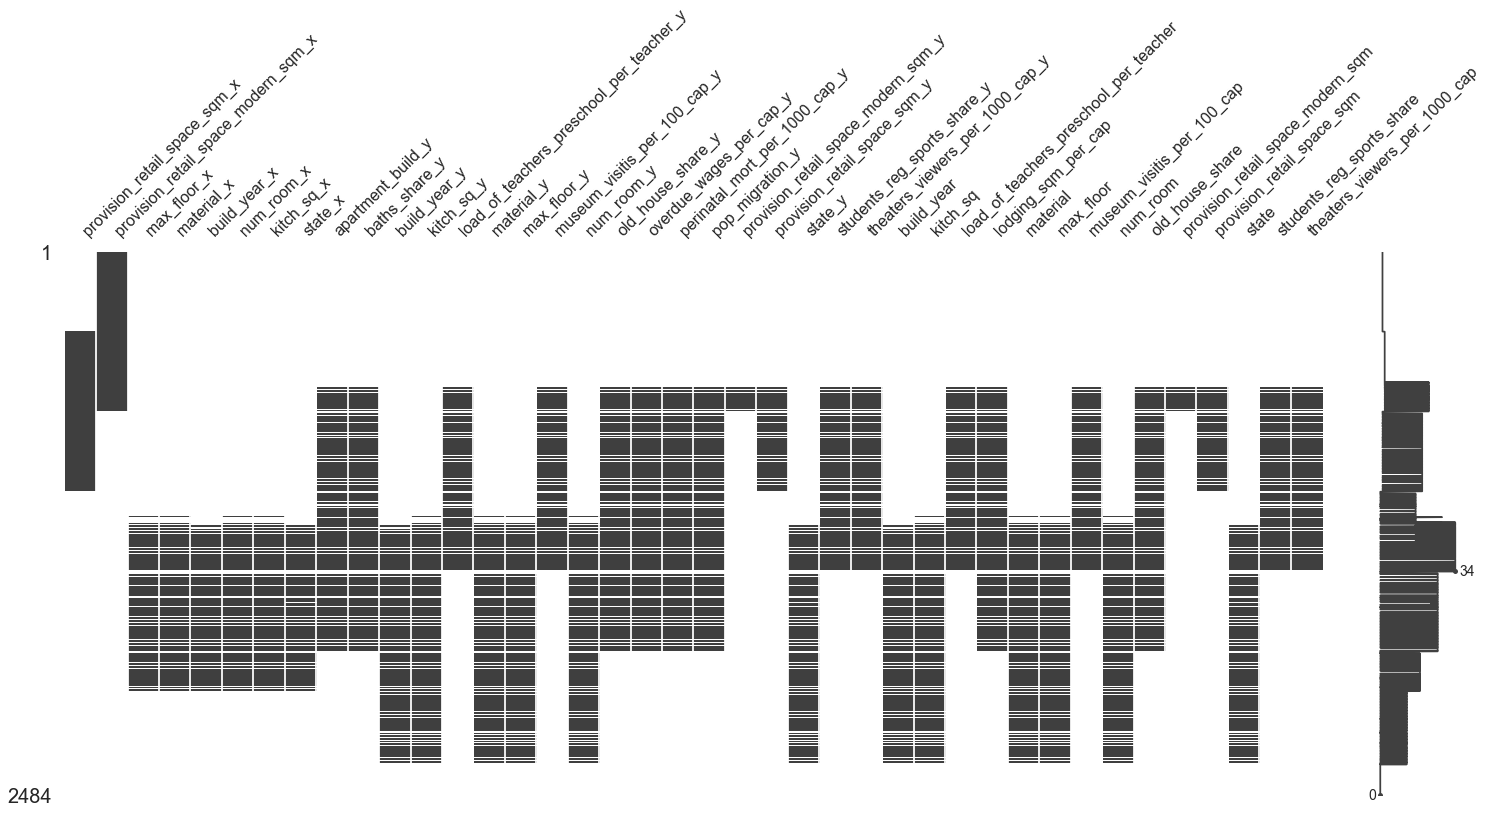

In [550]:
import missingno as msno

macro_df.set_index('timestamp')
filtered_data = msno.nullity_filter(macro_df, filter='bottom', n=40, p=0.90) # or filter='top'

msno.missingno.matrix(filtered_data)

### Cleaning Missing and Incorrect Values

In [377]:
# Cleaning values with incorrect information 
train_df.loc[train_df['state'] == 33, 'status'] = 3
train_df = train_df.loc[train_df['id'] != 24718] 
train_df = train_df.loc[train_df['floor'] != 0] 

#### Cleaning the build year

In [378]:
train_df.loc[train_df['build_year'] == 20052009, 'build_year'] = 2009
train_df.loc[train_df['build_year'] == 215, 'build_year'] = 2015
train_df = train_df.loc[train_df['build_year'] != 4965, :]
df.loc[df['build_year'] == 0, 'build_year'] = 2015
df.loc[df['build_year'] == 1, 'build_year'] = 2016
df.loc[df['build_year'] == 2, 'build_year'] = 2017

#### Distribution of different GDP Features

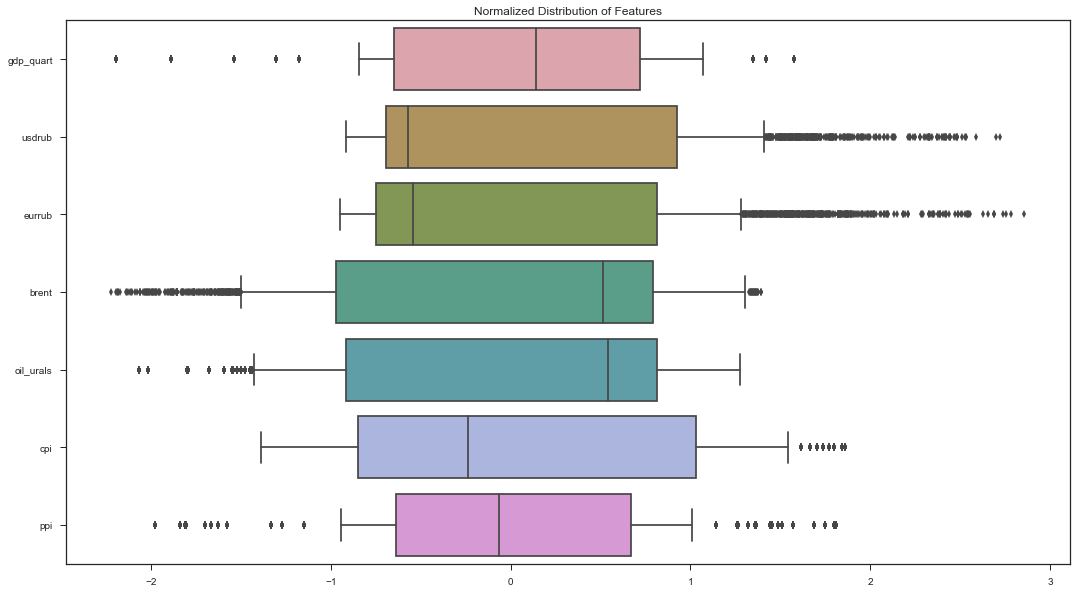

In [621]:
from sklearn import preprocessing

gdp_df = macro_df[['gdp_quart','usdrub','eurrub',
           'brent','oil_urals', 'cpi', 'ppi']]

gdp_df = gdp_df.loc[gdp_df['gdp_quart'].notnull(),:] # remove nulls
plt.figure(figsize=(18,10))
plt.title('Normalized Distribution of Features')
sns.boxplot(rescale(gdp_df),saturation=0.5,orient='horizontal',whis=.3) # plot scale
plt.show()

#### Time-Series Analysis

In [380]:
print 'Start Date for Null gdp_quart: {0}'.format(macro_df.loc[macro_df['gdp_quart'].isnull(), 'timestamp'].min())
print 'End Date for Null gdp_quart: {0}'.format(macro_df.loc[macro_df['gdp_quart'].isnull(), 'timestamp'].max())

Start Date for Null gdp_quart: 2010-01-01 00:00:00
End Date for Null gdp_quart: 2010-03-31 00:00:00


In [382]:
df.loc[df['year'] == 2011, :]

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,water_treatment_km,work_all,work_female,work_male,workplaces_km,year,young_all,young_female,young_male,zd_vokzaly_avto_km
0,18654,8945,9709,23603,11317,12286,9576,4677,4899,17508,...,23.683460,98207,45930,52277,0.884350,2011.0,21154,10147,11007,14.231961
1,13729,6800,6929,17700,8702,8998,6880,3414,3466,15164,...,1.317476,70194,34572,35622,0.686252,2011.0,15727,7802,7925,9.242586
2,11252,5336,5916,14884,7063,7821,5879,2784,3095,19401,...,4.912660,63388,31575,31813,1.510089,2011.0,13028,6193,6835,9.540544
3,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,...,15.623710,120381,60341,60040,0.622272,2011.0,28563,13883,14680,17.478380
4,11631,5408,6223,15237,7124,8113,5706,2724,2982,5164,...,10.683540,68043,33807,34236,0.892668,2011.0,13368,6209,7159,1.595898
5,4632,2233,2399,5866,2831,3035,2418,1194,1224,4851,...,7.186740,29660,13867,15793,1.042262,2011.0,5291,2547,2744,5.070197
6,4884,2377,2507,6510,3165,3345,2459,1218,1241,19445,...,13.900700,35003,17513,17490,0.544312,2011.0,5682,2757,2925,3.028547
7,18654,8945,9709,23603,11317,12286,9576,4677,4899,17508,...,23.118380,98207,45930,52277,1.098572,2011.0,21154,10147,11007,14.434462
8,12269,5782,6487,15510,7309,8201,6507,3051,3456,17662,...,20.940970,59120,29456,29664,0.256589,2011.0,13901,6557,7344,7.500715
9,17469,8387,9082,22071,10587,11484,9347,4541,4806,15929,...,16.753090,85551,42199,43352,0.150686,2011.0,19784,9445,10339,10.229145


In [383]:
df_sorted = df.set_index('timestamp').sort_index()


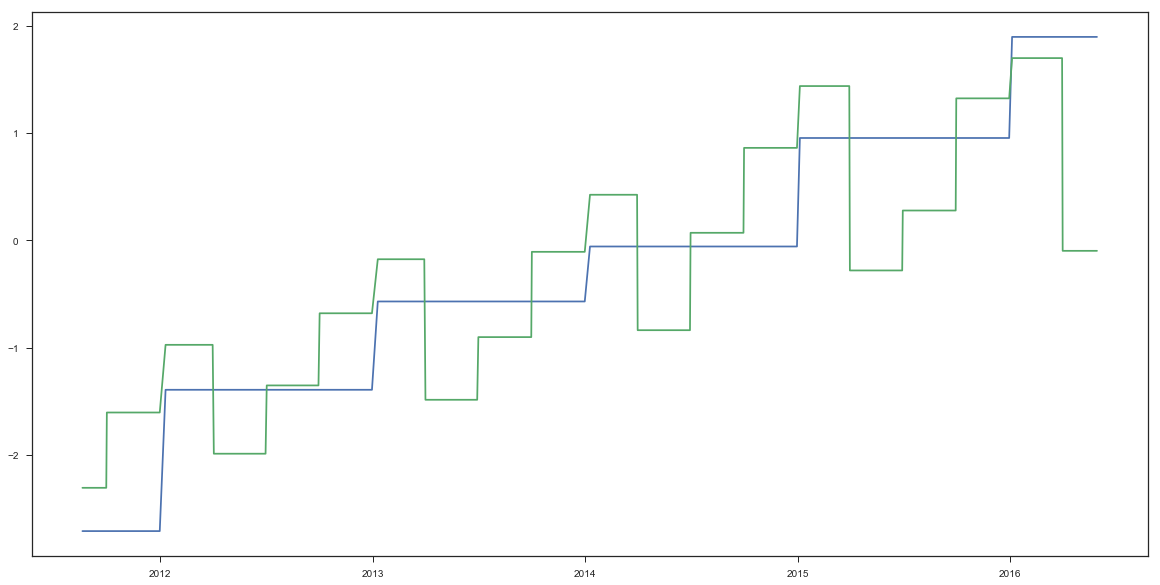

In [384]:
macro_df.set_index('timestamp')
macro_df.columns

plt.figure(figsize=(20, 10))
plt.plot(rescale(df_sorted[['gdp_deflator','gdp_quart']]))
plt.show()

In [385]:
df_sorted[['gdp_deflator','gdp_quart']].corr()

,gdp_deflator,gdp_quart
gdp_deflator,1.00000,0.75257
gdp_quart,0.75257,1.00000


In [386]:
df_sorted[['gdp_deflator','gdp_quart']].describe()

,gdp_deflator,gdp_quart
count,38133.000000,38133.000000
mean,114.054290,18751.536470
std,10.086887,1923.972011
min,86.721000,14313.700000
25%,108.299000,17138.900000
50%,113.465000,18561.300000
75%,123.661000,20406.900000
max,133.160000,22016.100000


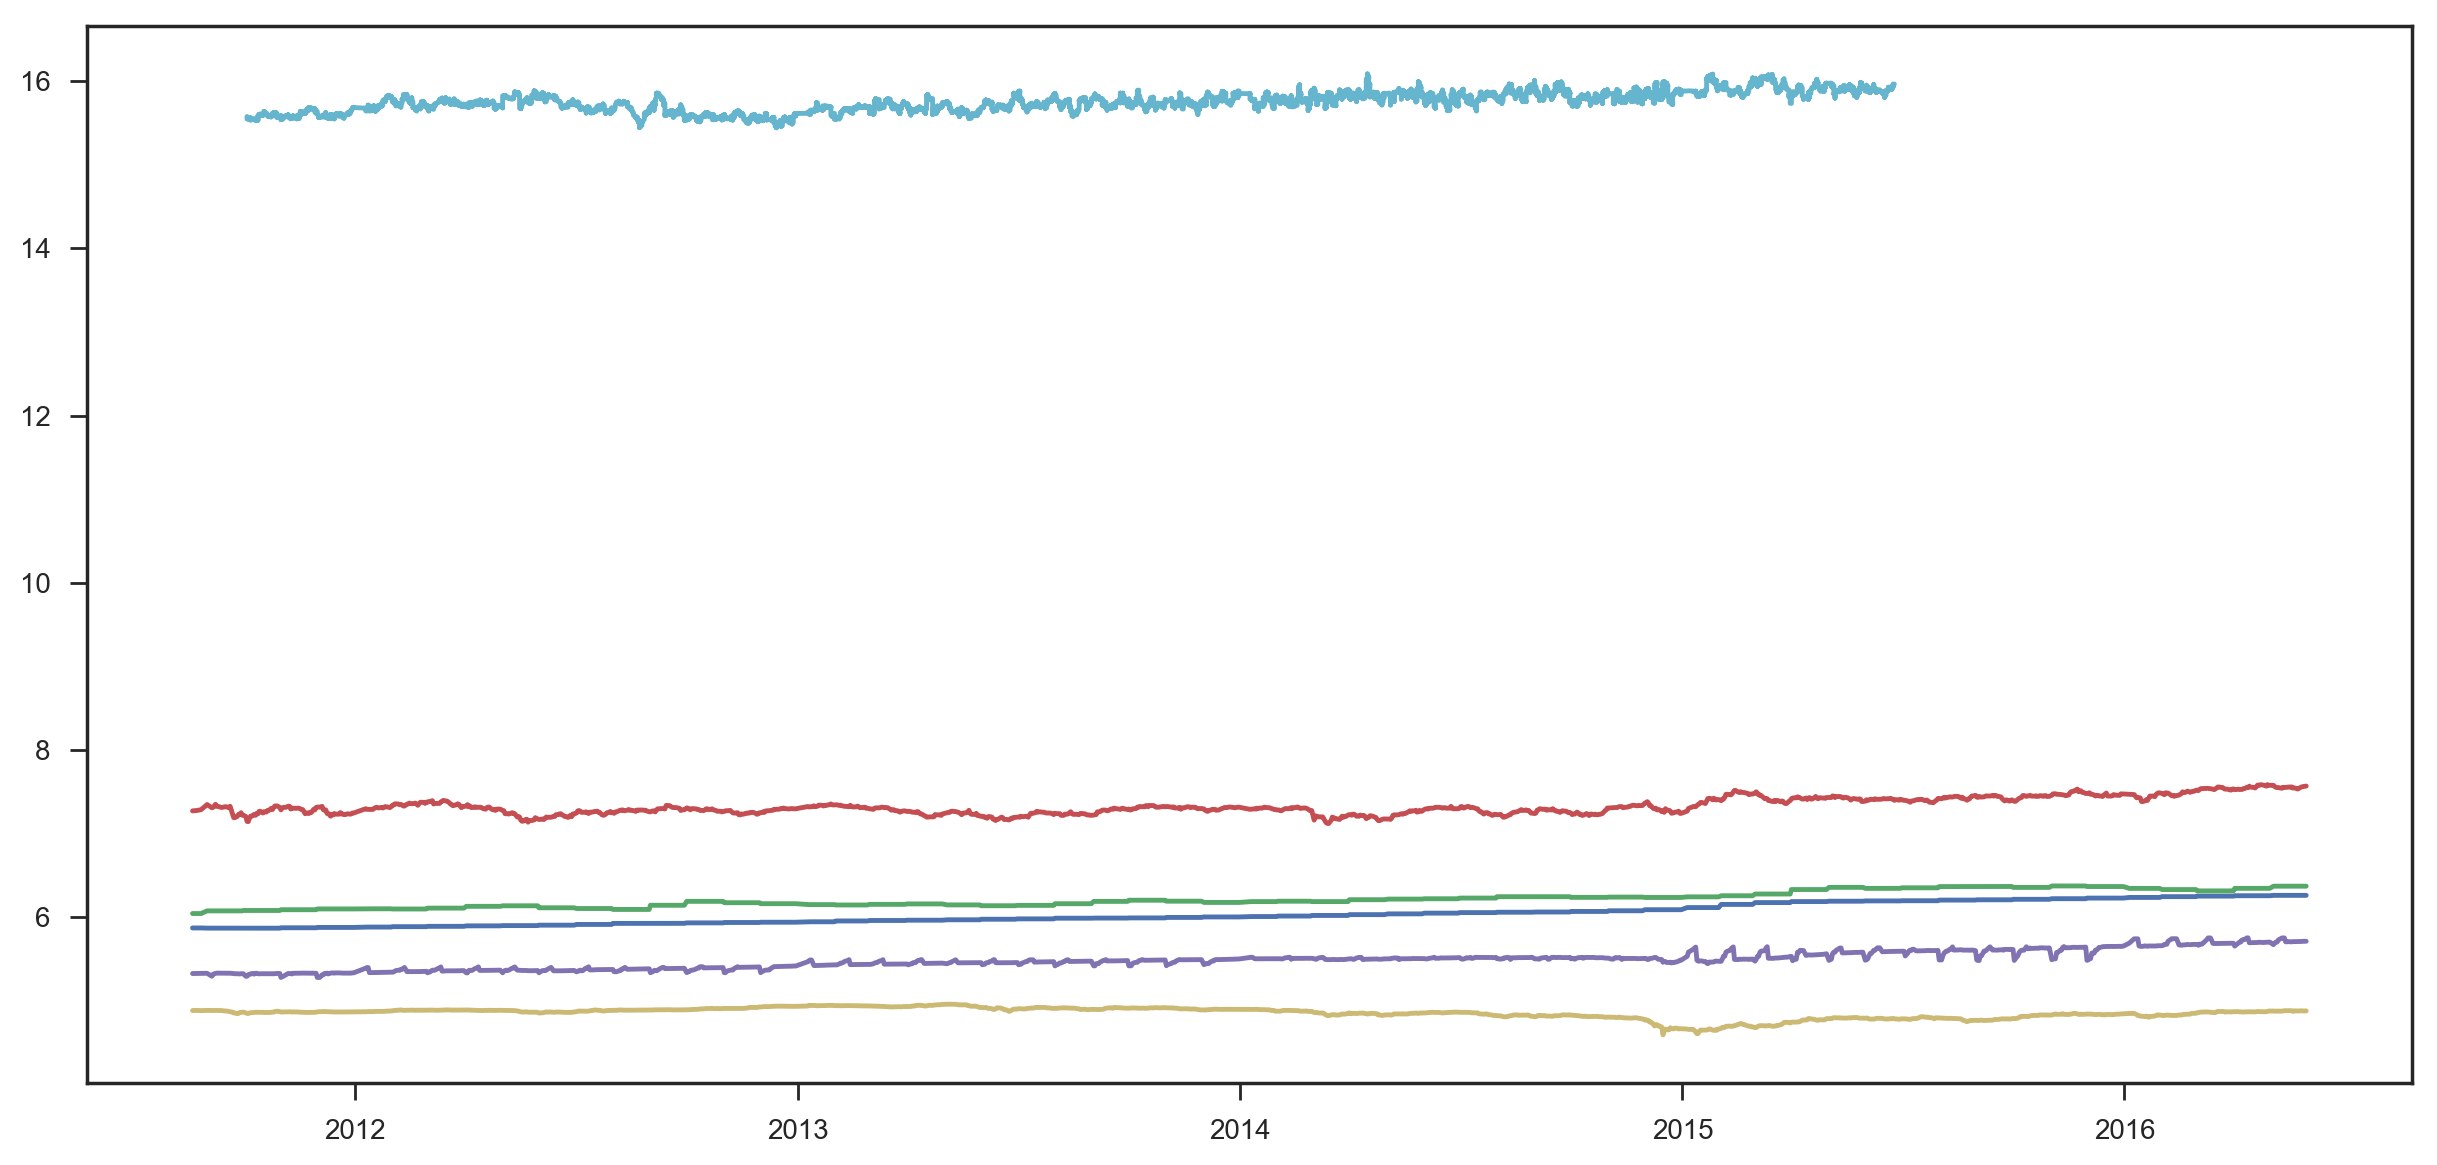

In [618]:
plt.figure(figsize=(15, 7), dpi=200)
plt.plot(np.log1p(df_sorted['cpi']))
plt.plot(np.log1p(df_sorted['ppi']))
plt.plot(np.log1p(df_sorted['micex']))
plt.plot(np.log1p(df_sorted['micex_cbi_tr']))
plt.plot(np.log1p(df_sorted['micex_rgbi_tr']))
plt.plot(np.log1p(trend))
plt.show()